In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import pandas as pd
import re
import os
# import torchvision

In [3]:
import torch as th
from torch import nn
from torch.autograd import Variable
import pandas as pd

In [9]:
metrics_testbed = pd.read_csv('data/metrics_stat_testbed_6m_4c.csv')
metrics_testbed_fast = metrics_testbed.loc[metrics_testbed['is_slow'] == 0]
metrics_testbed_slow = metrics_testbed.loc[metrics_testbed['is_slow'] == 1]


metrics_testbed_pruned = pd.read_csv('data/metrics_stat_testbed_6m_4c_pruned.csv')
metrics_testbed_pruned_slow = metrics_testbed_pruned.loc[metrics_testbed_pruned['is_slow'] == 1]

In [11]:
fast_time_orig = np.mean(metrics_testbed_fast['total_train_time'])
time_orig = np.mean(metrics_testbed_slow['total_train_time'])
time_pruned = np.mean(metrics_testbed_pruned_slow['total_train_time'])

print("fast_time_orig:", fast_time_orig,"time_orig: ", time_orig, "time_pruned: ", time_pruned)

fast_time_orig: 589551.15 time_orig:  1987835.35 time_pruned:  693834.35


In [97]:
conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1,padding=0)  ##output shape (batch, 32, 28, 28)self.pool1 = nn.MaxPool2d(2, stride=2) ## output shape (batch, 32, 14, 14)
pool1 = nn.MaxPool2d(2, stride=2)  ## output shape (batch, 64, 7, 7)

conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0)  ##output shape (batch, 64, 14, 14)
pool2 = nn.MaxPool2d(2, stride=2)  ## output shape (batch, 64, 7, 7)

fc1 = nn.Linear(2592, 1024)  ##input of [BatchSize, 3136]. output of [BatchSize, 2048]
fc2 = nn.Linear(1024, 62)  ##input of [BatchSize, 2048]. output of [BatchSize, 62]


In [98]:
# trainFile = '/content/drive/My Drive/leaf/data/femnist/data/train/users/f0016_39.json'
trainFile = './slow_client_train_500.json'#'/content/drive/My Drive/leaf/data/femnist/data/train/users/sample.json'
testFile = './slow_client_test_150.json'#'/content/drive/My Drive/leaf/data/femnist/data/test/users/sample_test.json'
# testFile = '/content/drive/My Drive/leaf/data/femnist/data/test/users/f0016_39.json'

femnistUser = {}
with open(trainFile, 'r') as f:
  femnistUser = json.load(f)

femnistUser_test = {}
with open(testFile, 'r') as f:
  femnistUser_test = json.load(f) 


In [99]:
dataX = np.array(femnistUser['x'])
dataY = np.array(femnistUser['y'])

dataX_test = np.array(femnistUser_test['x'])
dataY_test = np.array(femnistUser_test['y'])

# for i in range(len(dataY)):
#   dataY[i] = dataY[i] % 5#

In [100]:
train_X = th.tensor((dataX), dtype=th.float)
x = train_X[:1].view(-1, 1, 28, 28)

x = conv1(x)
x = th.nn.functional.relu(x)
x = pool1(x)
print(x.shape)

torch.Size([1, 16, 12, 12])


In [68]:
# def cross_entropy_with_logits(log_logits, targets, batch_size):
#     eps = 1e-7
#     return -(targets * th.log(log_logits + eps)).sum() / batch_size

def softmax_cross_entropy_with_logits(logits, targets, batch_size):
    """ Calculates softmax entropy
        Args:
            * logits: (NxC) outputs of dense layer
            * targets: (NxC) one-hot encoded labels
            * batch_size: value of N, temporarily required because Plan cannot trace .shape
    """
    # numstable logsoftmax
    norm_logits = logits - logits.max(dim = 1, keepdim = True)[0]

    log_probs = norm_logits - norm_logits.exp().sum(dim=1, keepdim=True).log()
    
    # NLL, reduction = mean
    return -(targets * log_probs).sum() / batch_size

In [69]:
def naive_sgd(param, **kwargs):
  return param - kwargs['lr'] * param.grad

In [70]:
def set_model_params(module, params_list, start_param_idx=0):
    """ Set params list into model recursively
    """
    param_idx = start_param_idx

    for name, param in module._parameters.items():
        module._parameters[name] = Variable(params_list[param_idx], requires_grad=True)
        param_idx += 1

    for name, child in module._modules.items():
        if child is not None:
            param_idx = set_model_params(child, params_list, param_idx)

    return param_idx

In [71]:
def convert_to_one_hot_plan(input_data, classes=5):
    one_hot_labels = nn.functional.one_hot(input_data, classes)
    return one_hot_labels

In [85]:
class FemnistNet(nn.Module):
    def __init__(self):
        super(FemnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2) ##output shape (batch, 32, 28, 28)
        self.pool1 = nn.MaxPool2d(2, stride=2, ) ## output shape (batch, 32, 14, 14)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) ##output shape (batch, 64, 14, 14)
        self.pool2 = nn.MaxPool2d(2, stride=2) ## output shape (batch, 64, 7, 7)

        self.fc1 = nn.Linear(3136, 2048)
        self.fc2 = nn.Linear(2048 ,62)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = th.nn.functional.relu(x)
        x = self.pool1(x)

        x=self.conv2(x)
        x = th.nn.functional.relu(x)
        x = self.pool2(x)

        x = x.flatten(start_dim=1)

        x = self.fc1(x)
        l1_activations = th.nn.functional.relu(x)

        x = self.fc2(l1_activations)

        return x, l1_activations

In [73]:
class FemnistNetSmall(nn.Module):
    def __init__(self):
        super(FemnistNetSmall, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) ##output shape (batch, 32, 28, 28)self.pool1 = nn.MaxPool2d(2, stride=2) ## output shape (batch, 32, 14, 14)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) ##output shape (batch, 64, 14, 14)
        self.pool2 = nn.MaxPool2d(2, stride=2) ## output shape (batch, 64, 7, 7)
        
        self.fc1 = nn.Linear(1568, 1024) ##input of [BatchSize, 3136]. output of [BatchSize, 2048]
        self.fc2 = nn.Linear(1024 ,62) ##input of [BatchSize, 2048]. output of [BatchSize, 62]

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = th.nn.functional.relu(x)

        x = self.pool1(x)

        x=self.conv2(x)
        x = th.nn.functional.relu(x)
        
        x = self.pool2(x)
        
        x = x.flatten(start_dim=1)
        
        x = self.fc1(x)
        l1_activations = th.nn.functional.relu(x)
        
        x = self.fc2(l1_activations)

        return x, l1_activations

In [86]:
seed = 1549775860
th.random.manual_seed(seed)
th.manual_seed(seed)
model = FemnistNet()
modelParams = [param.data for param in model.parameters()] 

In [75]:
# weights = np.load('weights_for_round_215.npy',allow_pickle=True)
seed = 1549775860
th.random.manual_seed(seed)
th.manual_seed(seed)
model_small = FemnistNetSmall() ##model
model_params_small = [param.data for param in model_small.parameters()]

In [76]:
# for item, param in zip(weights,model.parameters()):
#     _tensor = th.from_numpy(item)
#     param.data.copy_(_tensor)
# modelParams = [model_param.data for model_param in model.parameters()]

In [88]:
def get_average_over_examples(activations, total_examples):
    reduced_sum = th.sum(activations, dim=0)#reduce(th.add, activations)
    return th.div(reduced_sum, total_examples)


def training_plan(X, y, batch_size, lr, model_params):
    model.train()
    
    # inject params into model
    set_model_params(model, model_params)
    
    
    logits, activations = model.forward(X)
    loss = softmax_cross_entropy_with_logits(logits, y, batch_size)
    
#     l2_penalty = 0.001 * sum([(p**2).sum() for p in model_params])
#     loss_with_penalty = loss + l2_penalty
#     print(type(loss))
    loss.backward()
    
    updated_params = [
        naive_sgd(param, lr=lr)
        for param in model_params
    ]
        
#     gradients = [th.max(param.grad) for param in model_params]
#     np.set_printoptions(threshold=np.inf)
# #     np_weights = np.array(gradients)
#     np.save('gradients_1', gradients)

    # accuracy
    pred = th.argmax(logits, dim=1)
    target = th.argmax(y, dim=1)
    acc = pred.eq(target).sum()/ batch_size
    
#     print("Acc:", acc)
    
    avg_act_over_examples = get_average_over_examples(activations, list(X.shape)[0])
    
    
    return (
        loss,
        acc,
        logits,
        avg_act_over_examples,
        *updated_params,        
    )

def training_plan_small(X, y, batch_size, lr, model_params):
    model.train()
    
    # inject params into model
    set_model_params(model, model_params)
    
    
    logits, activations = model.forward(X)
    loss = softmax_cross_entropy_with_logits(logits, y, batch_size)

    loss.backward()
    
    updated_params = [
        naive_sgd(param, lr=lr)
        for param in model_params
    ]

    # accuracy
    pred = th.argmax(logits, dim=1)
    target = th.argmax(y, dim=1)
    acc = pred.eq(target).sum()/ batch_size
    
#     print("Acc:", acc)
    
    avg_act_over_examples = get_average_over_examples(activations, list(X.shape)[0])
    
    
    return (
        loss,
        acc,
        logits,
        avg_act_over_examples,
        *updated_params,        
    )

In [82]:
def training_plan_small(X, y, batch_size, lr, model_params):
    model_small.train()
    
    # inject params into model
    set_model_params(model_small, model_params)
    model_small.float()
    
    X = Variable(th.tensor(X, dtype=th.float), requires_grad=True)
    y = Variable(th.tensor(y, dtype=th.float))
    
    
    logits, activations = model.forward(X)
    loss = softmax_cross_entropy_with_logits(logits, y, batch_size)

    loss.backward()
    
    updated_params = [
        naive_sgd(param, lr=lr)
        for param in model_params
    ]

    # accuracy
    pred = th.argmax(logits, dim=1)
    target = th.argmax(y, dim=1)
    acc = pred.eq(target).sum()/ batch_size
    
#     print("Acc:", acc)
    
    avg_act_over_examples = get_average_over_examples(activations, list(X.shape)[0])
    
    
    return (
        loss,
        acc,
        logits,
        avg_act_over_examples,
        *updated_params,        
    )

In [83]:
def evaluate_model_plan(X, y, batch_size, model_params):
    # Load model params into the model
    set_model_params(model, model_params)

    model_small.eval()
#     model.float()

    X = Variable(th.tensor(X, dtype=th.float), requires_grad=True)
    y = Variable(th.tensor(y, dtype=th.float))
    
    # Test
    logits, activations = model(X)
    preds = th.argmax(logits, dim=1)
    target = th.argmax(y, dim=1)
    
    acc = preds.eq(target).sum().float() / batch_size
    loss = softmax_cross_entropy_with_logits(logits, y, batch_size)#cross_entropy_with_logits(logits, y, batch_size)
    
    print(acc, loss)
    
    return acc, loss

In [84]:
torch_accs = []
torch_losses = []

batch_size = th.tensor([float(20)])
lr = th.tensor([0.0003])

X = th.tensor(dataX)
y = nn.functional.one_hot(th.tensor(dataY), 62)

X_test = th.tensor(dataX_test)
y_test = nn.functional.one_hot(th.tensor(dataY_test), 62)
len_data_y = len(dataY) 


for e in range(150):
  
  epoch_acc, epoch_loss = evaluate_model_plan(X_test, y_test, 150, model_params_small)
  print("Epoch:", e, "Loss:" ,epoch_loss, "Accuracy:", epoch_acc, "len(y_test)", 150)

  batch_losses = []
  batch_accs = []
  totalBatches = math.ceil(len(dataY)/batch_size)
  # totalBatches = 1

    
  for b in range(totalBatches):
    secondIndex = (b + 1) * int(batch_size) if (b + 1) * int(batch_size) <= len_data_y else len_data_y

    x_b = X[b * int(batch_size) : secondIndex]
    y_b = y[b * int(batch_size) : secondIndex]
    
#     print("Batch ",b+1, y_b.argmax(-1))
    
    if x_b.shape[0] == 0:
      continue
    
    loss, acc, _, _,  *updatedParams = training_plan_small(x_b, y_b, 20, lr, model_params_small)
    
    model_params_small = updatedParams
    
    
#     print(f"Updated parameters for batch {b} {modelParams[7]}")
#     print("gradient", gradient)

    batch_accs.append(float(acc))
    batch_losses.append(float(loss))

#   break
    torch_losses.append(epoch_loss)
    torch_accs.append(epoch_acc)

tensor(0.0200) tensor(12.4074, grad_fn=<DivBackward0>)
Epoch: 0 Loss: tensor(12.4074, grad_fn=<DivBackward0>) Accuracy: tensor(0.0200) len(y_test) 150


/home/aliza16/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/aliza16/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


TypeError: unsupported operand type(s) for *: 'Tensor' and 'NoneType'

In [47]:
# femnist_stat = pd.read_csv('/content/drive/My Drive/leaf/models/metrics/femnist/femnist_stat.csv')
femnist_stat = pd.read_csv('data/metrics_stat.csv')
femnist_stat_train = femnist_stat[femnist_stat['set'] == 'test']
femnist_loss = list(femnist_stat['loss'])

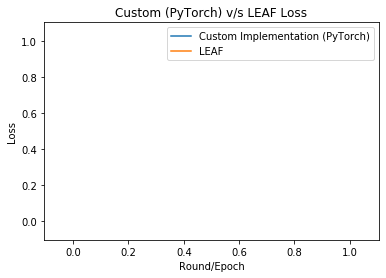

In [48]:
plt.plot(torch_losses)
plt.plot(list(femnist_stat_train['loss'])[0:len(torch_losses)])

plt.title('Custom (PyTorch) v/s LEAF Loss')
plt.ylabel('Loss')
plt.xlabel('Round/Epoch')

plt.legend(['Custom Implementation (PyTorch)', 'LEAF'], loc='upper right')

plt.savefig('custom_v_leaf_femnist_loss')
plt.show()

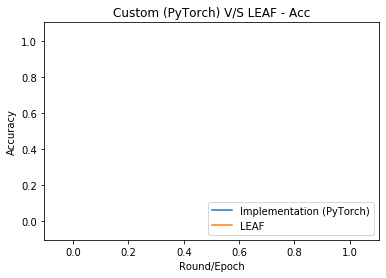

In [49]:
plt.plot(torch_accs)
plt.plot(list(femnist_stat_train['accuracy'])[:len(torch_accs)])


plt.title('Custom (PyTorch) V/S LEAF - Acc')

plt.ylabel('Accuracy')
plt.xlabel('Round/Epoch')

plt.legend(['Implementation (PyTorch)', 'LEAF'], loc='lower right')

plt.savefig('custom_v_leaf_femnist_acc')
plt.show()

In [1]:
print(torch_accs)

NameError: name 'torch_accs' is not defined